# **IMPORTING LIBRARIES**

In [ ]:
import warnings
import seaborn as sns
import numpy as np 
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# **LOADING DATA**

In [ ]:
data = pd.read_csv("spam.csv",encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
#data = pd.read_csv("spam.csv", encoding='latin-1')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
# Dropping the redundent looking collumns (for this project)
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
data = data.drop(data[to_drop], axis=1)
# Renaming the columns because I feel fancy today 
data.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
data.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


*Bộ dữ liệu bao gồm 5.574 tin nhắn bằng tiếng Anh. Dữ liệu được chỉ định là ham hoặc thư rác. DataFrame có hai cột. Cột đầu tiên là "Target" biểu thị lớp tin nhắn là ham hoặc spam và cột "Text" thứ hai là chuỗi văn bản.*

# **DATA EXPLORATION**

Text(0, 0.5, 'Number of Data points')

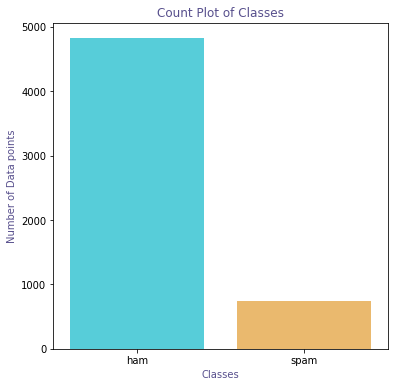

In [ ]:
#Palette
cols= ["#41DFEF", "#FFBD59"] 
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(6,6))
fg = sns.countplot(x= data["Target"], palette= cols)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

*Nhận xét: Từ biểu đồ ở trên, sự mất cân bằng dữ liệu là khá rõ ràng.*

## **FEATURE ENGINEERING**

Với mục đích khám phá dữ liệu, chúng ta sẽ tạo các thuộc tính mới
- No_of_Characters: Số ký tự trong tin nhắn văn bản
- No_of_Words: Số từ trong tin nhắn văn bản
- No_of_sentence: Số câu trong tin nhắn văn bản

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#Adding a column of numbers of charachters,words and sentences in each msg
data["No_of_Characters"] = data["Text"].apply(len)
data["No_of_Words"]=data.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
data["No_of_sentence"]=data.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

data.describe().T

,count,mean,std,min,25%,50%,75%,max
No_of_Characters,5572.0,80.118808,59.690841,2.0,36.0,61.0,121.0,910.0
No_of_Words,5572.0,18.695621,13.742587,1.0,9.0,15.0,27.0,220.0
No_of_sentence,5572.0,1.970747,1.417778,1.0,1.0,1.0,2.0,28.0


<Figure size 864x576 with 0 Axes>

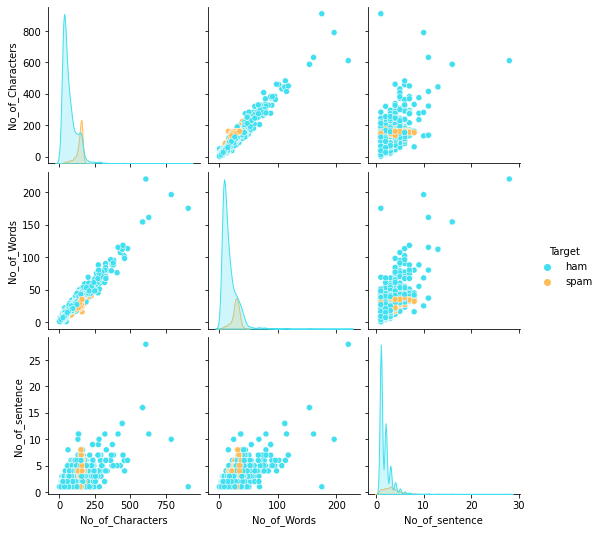

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

*Nhận xét: Từ biểu đồ, chúng ta có thể thấy một vài ngoại lệ trong tất cả các lớp ham. Điều này thật thú vị vì chúng ta có thể đặt một giới hạn cho một trong những điều này. Vì về cơ bản chúng chỉ ra cùng một điều, tức là độ dài của SMS.*

## **OUTLIER DETECTION**

In [ ]:
#Dropping the outliers. 
data = data[(data["No_of_Characters"]<350)]
data.shape

(5548, 5)

<Figure size 864x576 with 0 Axes>

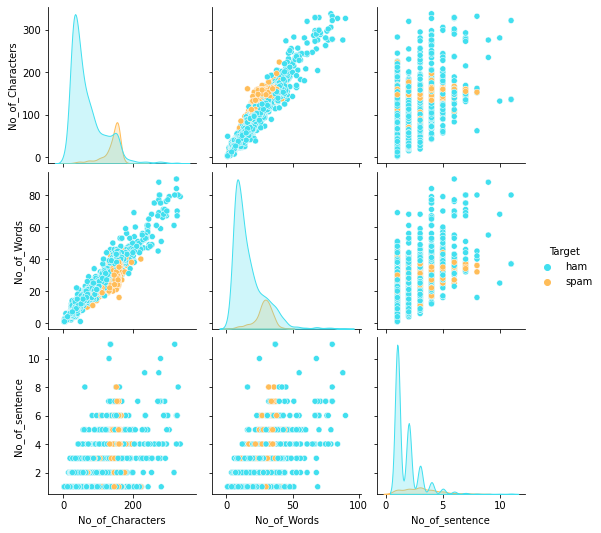

In [ ]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=data, hue="Target",palette=cols)
plt.show(fg)

# **DATA PREPROCESSING**

Cleaning text ➡ Tokenization ➡ Removing Stopwords ➡ Lemmatization

## CLEANING TEXT - Làm sạch văn bản


Quá trình làm sạch dữ liệu NLP là rất quan trọng. Máy tính không hiểu văn bản. Đối với máy tính, nó chỉ là một cụm ký hiệu. Để tiếp tục xử lý dữ liệu, chúng tôi cần làm cho dữ liệu sạch hơn.
- Trong bước đầu tiên, chúng tôi chỉ trích xuất các ký tự chữ cái, chúng tôi loại bỏ dấu câu và số.
- Trong bước tiếp theo, chúng tôi sẽ chuyển đổi tất cả các ký tự thành chữ thường.

Văn bản này sau đó sẽ được sử dụng trong phân tích kỹ thuật tiếp theo

In [ ]:
#Lets have a look at a sample of texts before cleaning
print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m",*data["Text"][:5], sep = "\n")

 The First 5 Texts:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [ ]:
# Defining a function to clean up the text
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

data["Clean_Text"] = data["Text"].apply(Clean)
#Lets have a look at a sample of texts after cleaning
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*data["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


## TOKENIZATION

Mã hóa là chia nhỏ dữ liệu phức tạp thành các đơn vị nhỏ hơn được gọi là mã thông báo. Nó có thể được thực hiện bằng cách tách đoạn văn thành câu và câu thành từ. Tôi đang tách Clean_Text thành các từ ở bước này.

In [ ]:
data["Tokenize_Text"]=data.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m",*data["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


## REMOVING STOPWORDS

Từ dừng là những từ xuất hiện thường xuyên (chẳng hạn như ít, là, an, v.v.). Những từ này giữ ý nghĩa trong cấu trúc câu, nhưng không đóng góp nhiều vào quá trình xử lý ngôn ngữ trong NLP. Với mục đích loại bỏ phần dư thừa trong quá trình xử lý của chúng tôi, tôi sẽ loại bỏ những phần đó. Thư viện NLTK có một tập hợp các từ dừng mặc định mà chúng tôi sẽ xóa.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Removing the stopwords function
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

data["Nostopword_Text"] = data["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*data["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


## LEMMATIZATION

Tạo gốc là quá trình lấy dạng gốc của một từ. Thân hoặc rễ là phần mà các mối liên kết vô hướng được thêm vào. Phần gốc của một từ được tạo bằng cách loại bỏ tiền tố hoặc hậu tố của một từ. Nó quay trở lại từ nguyên của từ này. Ngôn ngữ phát triển theo thời gian. Nhiều ngôn ngữ khác nhau phân nhánh vào nhau; ví dụ, tiếng Anh là một phái sinh của tiếng Latinh. Do đó, việc đặt gốc một từ sẽ đưa nó trở lại từ gốc.

lemmatization cũng chuyển một từ về dạng gốc của nó. Tuy nhiên, sự khác biệt là sự bổ sung đảm bảo rằng từ gốc thuộc về ngôn ngữ mà người ta đang xử lý, trong trường hợp của chúng ta, đó là tiếng Anh. Nếu chúng ta sử dụng lemmatization, đầu ra sẽ là tiếng Anh.

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["Lemmatized_Text"] = data["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*data["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


# **VECTORIZE**

TF-IDF trong NLP là viết tắt của Term Frequency - Inverse document frequency. Trong NLP, dữ liệu được làm sạch cần được chuyển đổi thành một định dạng số trong đó mỗi từ được biểu diễn bằng một ma trận. Điều này còn được gọi là nhúng từ hoặc vector hóa từ.

Tần suất thuật ngữ (TF) = (Tần suất của một thuật ngữ trong tài liệu) / (Tổng số thuật ngữ trong tài liệu) Tần suất tài liệu nghịch đảo (IDF) = log ((tổng số tài liệu) / (số tài liệu có thuật ngữ t)) I sẽ sử dụng TfidfVectorizer () để vectơ hóa dữ liệu được xử lý trước.

Các bước trong Vectorizing:

- Tạo một kho văn bản bị lemmatized
- Chuyển đổi kho dữ liệu ở dạng vectơ
- Mã hóa nhãn cho các lớp trong Target

Lưu ý: Cho đến nay chúng tôi vẫn theo dõi các cột trong dữ liệu của mình với mục đích giải thích

In [ ]:
#Creating a corpus of text feature to encode further into vectorized form
corpus= []
for i in data["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


In [ ]:
#Changing text data in to numbers. 
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()
#Let's have a look at our feature 
X.dtype

dtype('float64')

In [ ]:
#Label encode the Target and use it as y
label_encoder = LabelEncoder()
data["Target"] = label_encoder.fit_transform(data["Target"])

# **MODEL BUILDING**

Các bước liên quan đến Xây dựng Mô hình
- Thiết lập các tính năng và nhắm mục tiêu dưới dạng X và y
- Tách bộ kiểm tra và đào tạo
- Xây dựng một hệ thống mô hình cho bốn bộ phân loại khác nhau.
  1. Naïve Bayes
  2. RandomForestClassifier
  3. KNeighborsClassifier
  4. Support Vector Machines
- Phù hợp với tất cả các mô hình trên dữ liệu đào tạo
- Nhận xác nhận chéo trên tập hợp đào tạo cho tất cả các mô hình để đảm bảo độ chính xác

In [ ]:
#Setting values for labels and feature as y and X(we already did X in vectorizing...)
y = data["Target"] 
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Testing on the following classifiers
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [ ]:
# Cossvalidation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.967552 
RandomForest: 0.975214 
KNeighbours: 0.911450 
SVC: 0.974086 


# **EVALUATING MODELS**


Testing the models on Testset
- Accuracy Report
- Confusion Matrix

In [ ]:
# Model Evaluation
# creating lists of varios scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [ ]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [ ]:
cmap2 = ListedColormap(["#41DFEF", "#FFBD59"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.000000,0.705882,0.827586,0.974775,0.997521
RandomForest,1.000000,0.801471,0.889796,0.974775,0.997521
KNeighbours,0.977778,0.323529,0.486188,0.974775,0.997521
SVC,0.990909,0.801471,0.886179,0.974775,0.997521


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMa

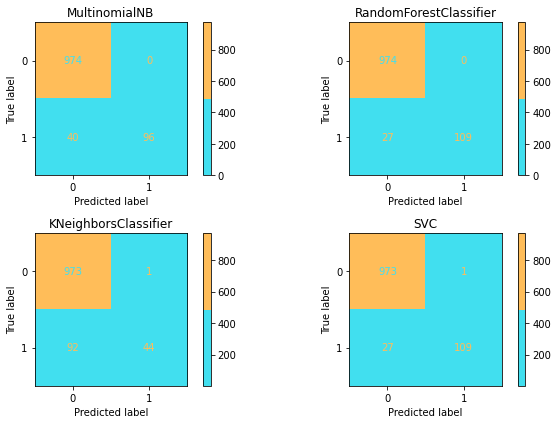

In [ ]:
cmap = ListedColormap(["#41DFEF", "#FFBD59"])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,6))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap= cmap,   
                          )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()
